In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Set random seed
np.random.seed(42)


In [ ]:
# Cell 2: Load Data, Model, and Artifacts
print("Loading data and models...")

# Load processed data
provider_features = pd.read_csv('../data/processed/provider_features_final.csv')

# Load the saved model and scaler
best_model = joblib.load('../models/best_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Load model info
try:
    with open('../models/model_info.json', 'r') as f:
        model_info = json.load(f)
    print("Model info loaded successfully.")
except FileNotFoundError:
    model_info = {
        'model_name': 'Unknown',
        'imbalance_strategy': 'Unknown',
        'feature_count': X_train.shape[1] if 'X_train' in locals() else 0,
        'training_samples': 0,
        'timestamp': 'Unknown'
    }
    print("Model info file not found. Using default values.")

print("=" * 60)
print("MODEL INFORMATION")
print("=" * 60)
print(f"Model Type: {model_info['model_name']}")
print(f"Imbalance Strategy: {model_info['imbalance_strategy']}")
print(f"Number of Features: {model_info['feature_count']}")
print(f"Training Samples: {model_info['training_samples']}")
print(f"Timestamp: {model_info['timestamp']}")


Loading data and models...
Model info loaded successfully.
MODEL INFORMATION
Model Type: Random Forest
Imbalance Strategy: Class Weighting
Number of Features: 38
Training Samples: 3787
Timestamp: 2025-12-01T21:59:47.265720


In [ ]:
# Cell 3: Prepare Test Data
def prepare_test_data(df, scaler):
    """
    Prepare test data using the same preprocessing as training
    """
    # Separate features and target
    X = df.drop(['Provider', 'PotentialFraud'], axis=1)
    y = df['PotentialFraud']
    providers = df['Provider']
    
    # Handle any remaining non-numeric columns
    for col in X.select_dtypes(include=['object']).columns:
        X = X.drop(columns=[col])
    
    # Ensure all training columns are present
    try:
        missing_cols = set(scaler.feature_names_in_) - set(X.columns)
        for col in missing_cols:
            X[col] = 0
        
        # Reorder columns to match training
        X = X[scaler.feature_names_in_]
    except AttributeError:
        # If scaler doesn't have feature_names_in_, use columns as is
        print("Using original feature order")
    
    # Scale features
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled, y, providers, X.columns.tolist()

# Prepare test data using 20% holdout
from sklearn.model_selection import train_test_split

# Create proper test set (20% of data) - consistent with modeling notebook
train_val_df, test_df = train_test_split(
    provider_features, test_size=0.2, random_state=42, stratify=provider_features['PotentialFraud']
)

X_test, y_test, test_providers, feature_names = prepare_test_data(test_df, scaler)

print("\n" + "=" * 60)
print("TEST SET INFORMATION")
print("=" * 60)
print(f"Test set shape: {X_test.shape}")
print(f"Test set fraud rate: {y_test.mean():.2%}")
print(f"Number of fraudulent providers in test: {sum(y_test == 1)}")
print(f"Number of non-fraudulent providers in test: {sum(y_test == 0)}")



TEST SET INFORMATION
Test set shape: (1082, 38)
Test set fraud rate: 9.33%
Number of fraudulent providers in test: 101
Number of non-fraudulent providers in test: 981


In [ ]:
# Cell 4: Final Model Evaluation on Test Set
print("\n" + "=" * 60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'PR-AUC': average_precision_score(y_test, y_pred_proba)
}

# Print metrics
print("\nPerformance Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Compare with validation metrics from model_info if available
if 'validation_metrics' in model_info:
    print("\nComparison with Validation Performance:")
    val_metrics = model_info['validation_metrics']
    for metric in test_metrics.keys():
        if metric in val_metrics:
            diff = test_metrics[metric] - val_metrics[metric]
            diff_pct = (diff / val_metrics[metric]) * 100 if val_metrics[metric] != 0 else 0
            print(f"  {metric}: Test={test_metrics[metric]:.4f}, Val={val_metrics[metric]:.4f}, Diff={diff:+.4f} ({diff_pct:+.1f}%)")



FINAL MODEL EVALUATION ON TEST SET

Performance Metrics:
  Accuracy: 0.9418
  Precision: 0.6727
  Recall: 0.7327
  F1-Score: 0.7014
  ROC-AUC: 0.9685
  PR-AUC: 0.7830

Comparison with Validation Performance:
  Accuracy: Test=0.9418, Val=0.9482, Diff=-0.0065 (-0.7%)
  Precision: Test=0.6727, Val=0.6949, Diff=-0.0222 (-3.2%)
  Recall: Test=0.7327, Val=0.8039, Diff=-0.0712 (-8.9%)
  F1-Score: Test=0.7014, Val=0.7455, Diff=-0.0440 (-5.9%)
  ROC-AUC: Test=0.9685, Val=0.9519, Diff=+0.0166 (+1.7%)
  PR-AUC: Test=0.7830, Val=0.7408, Diff=+0.0422 (+5.7%)



CONFUSION MATRIX ANALYSIS

Confusion Matrix:
                    Predicted
                   No      Yes
Actual No   ->     945       36
Actual Yes  ->      27       74

Detailed Analysis:
True Positive Rate (Sensitivity/Recall): 0.733
True Negative Rate (Specificity): 0.963
False Positive Rate: 0.037
False Negative Rate: 0.267
Positive Predictive Value (Precision): 0.673
Negative Predictive Value: 0.972


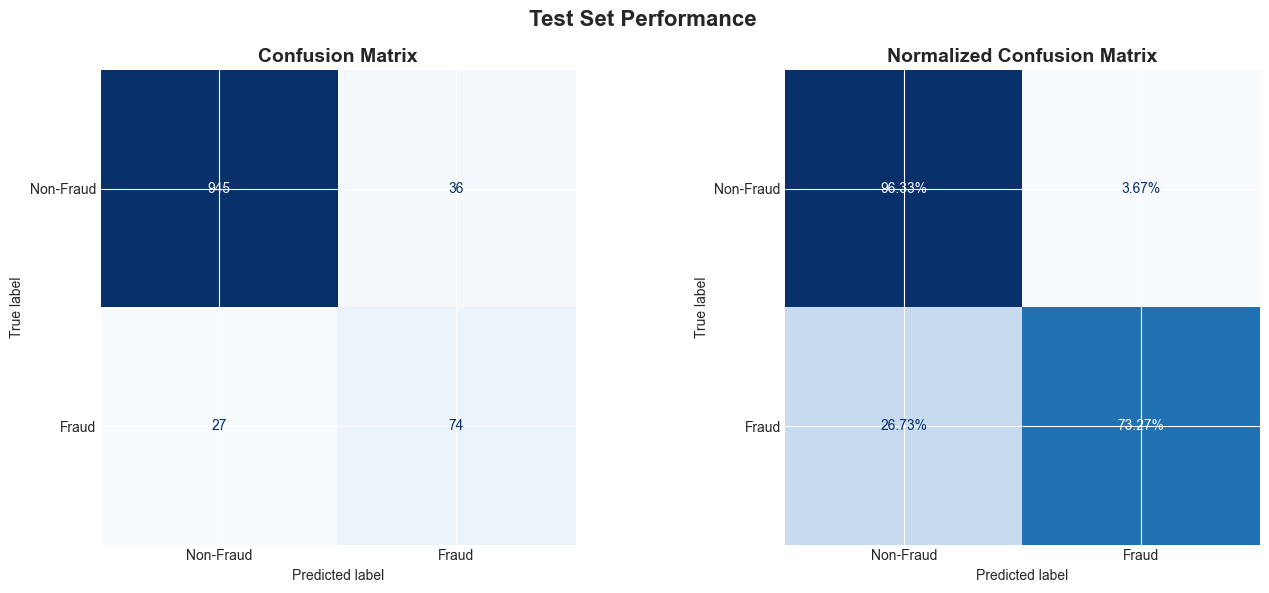

In [ ]:
# Cell 5: Confusion Matrix Analysis
print("\n" + "=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"                    Predicted")
print(f"                   No      Yes")
print(f"Actual No   ->    {tn:4d}     {fp:4d}")
print(f"Actual Yes  ->    {fn:4d}     {tp:4d}")

# Calculate rates
print(f"\nDetailed Analysis:")
print(f"True Positive Rate (Sensitivity/Recall): {tp/(tp+fn):.3f}")
print(f"True Negative Rate (Specificity): {tn/(tn+fp):.3f}")
print(f"False Positive Rate: {fp/(fp+tn):.3f}")
print(f"False Negative Rate: {fn/(fn+tp):.3f}")
print(f"Positive Predictive Value (Precision): {tp/(tp+fp) if (tp+fp)>0 else 0:.3f}")
print(f"Negative Predictive Value: {tn/(tn+fn) if (tn+fn)>0 else 0:.3f}")

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Plot 2: Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Non-Fraud', 'Fraud'])
disp_norm.plot(ax=axes[1], cmap='Blues', colorbar=False, values_format='.2%')
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.suptitle('Test Set Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()



ROC AND PRECISION-RECALL CURVES


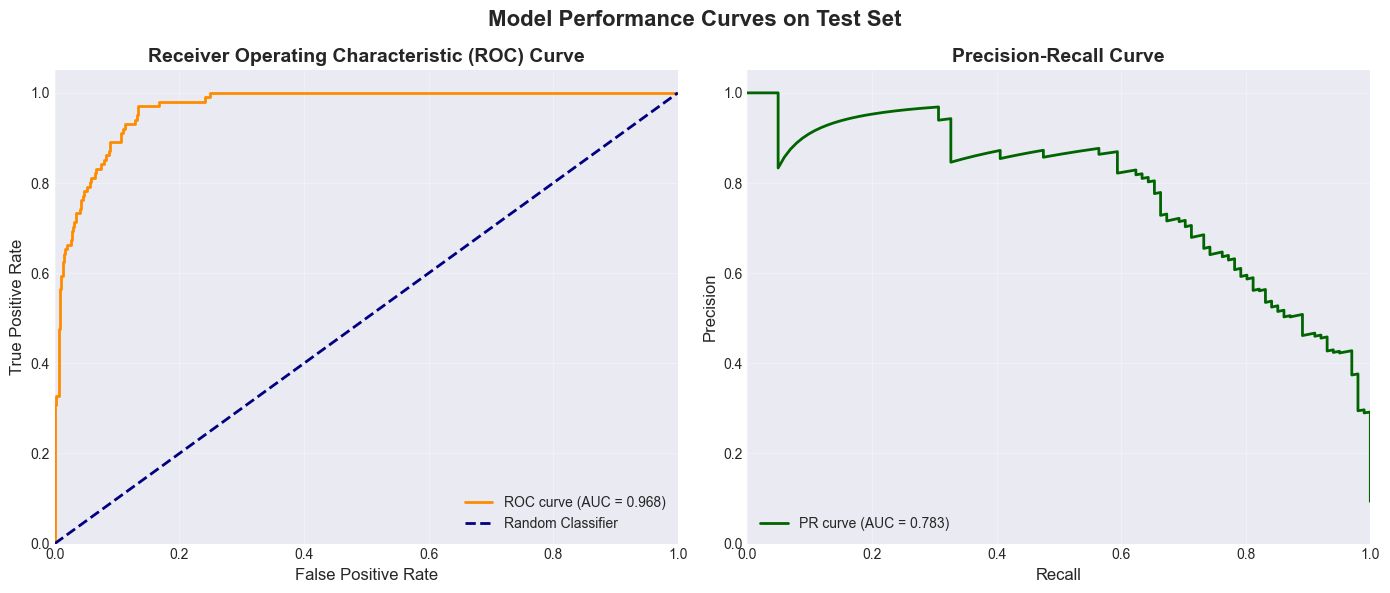

In [ ]:
# Cell 6: ROC and Precision-Recall Curves
print("\n" + "=" * 60)
print("ROC AND PRECISION-RECALL CURVES")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

axes[1].plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.suptitle('Model Performance Curves on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/performance_curves_test.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Cell 7: Error Analysis - Identify Misclassified Cases
print("\n" + "=" * 60)
print("ERROR ANALYSIS - MISCLASSIFIED CASES")
print("=" * 60)

# Create results dataframe
results_df = pd.DataFrame({
    'Provider': test_providers.values,
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability_Fraud': y_pred_proba
})

# Add misclassification flags
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']
results_df['False_Positive'] = (results_df['Actual'] == 0) & (results_df['Predicted'] == 1)
results_df['False_Negative'] = (results_df['Actual'] == 1) & (results_df['Predicted'] == 0)
results_df['True_Positive'] = (results_df['Actual'] == 1) & (results_df['Predicted'] == 1)
results_df['True_Negative'] = (results_df['Actual'] == 0) & (results_df['Predicted'] == 0)

print(f"\nClassification Summary:")
print(f"  Total cases: {len(results_df)}")
print(f"  Correctly classified: {results_df['Correct'].sum()} ({results_df['Correct'].mean():.1%})")
print(f"  Misclassified: {(~results_df['Correct']).sum()} ({(-results_df['Correct']).mean():.1%})")
print(f"  False Positives: {results_df['False_Positive'].sum()} ({results_df['False_Positive'].mean():.1%})")
print(f"  False Negatives: {results_df['False_Negative'].sum()} ({results_df['False_Negative'].mean():.1%})")
print(f"  True Positives: {results_df['True_Positive'].sum()} ({results_df['True_Positive'].mean():.1%})")
print(f"  True Negatives: {results_df['True_Negative'].sum()} ({results_df['True_Negative'].mean():.1%})")



ERROR ANALYSIS - MISCLASSIFIED CASES

Classification Summary:
  Total cases: 1082
  Correctly classified: 1019 (94.2%)
  Misclassified: 63 (5.8%)
  False Positives: 36 (3.3%)
  False Negatives: 27 (2.5%)
  True Positives: 74 (6.8%)
  True Negatives: 945 (87.3%)
